### 1. Imports

In [37]:
import pandas as pd

# visualization import
import matplotlib.pyplot as plt

# nltk imports
from nltk.corpus import stopwords

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # for model 1
from sklearn.naive_bayes import MultinomialNB # for model 2
from sklearn.ensemble import RandomForestClassifier # for model 2
from sklearn.metrics import ConfusionMatrixDisplay # for evaluation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # transforming data

### 2. Classification Modeling
Through the EDA process, I learned that a lot of the quantifiable elements of the posts in r/ADHD and r/autism are relatively similar. However, when I vectorized the word counts, I began to notice some discrepancies. What I would like to work further on in the future is how to train classificaiton models to place greater emphasis on the top words used heavily in one subreddit vs. the other. This is something that can be incredibly useful to narrow down on. <br>
For now, however, I will use both `CountVectorizer` and `TfidVectorizer` to transform my text data and model as normal. I will use `TfidVectorizer` since it will help narrow down on the frequency of words as well, which may strengthen our model's performance in the same way as I was hoping it would if I could place greater emphasis on the different words in each subreddit.

In [5]:
# read in cleaned & more concise data
df = pd.read_csv('./data/modeling_data.csv').drop('Unnamed: 0', axis = 1)

df.head()

,post_title,subreddit
0,So a bit of backstory I did my lifeguarding qu...,ADHD
1,So Adderall IRs were a total no-go for me Swit...,ADHD
2,Regular Ritalin IR works well but I don t like...,ADHD
3,I started vyvanse a few months ago 10 mg dose ...,ADHD
4,Evening has anyone who has a documented diagno...,ADHD


In [7]:
# define X & y
X = df['post_title']
y = df['subreddit']

In [96]:
# baseline
y.value_counts(normalize = True)

# NOTE: the baseline score (let's say r/ADHD is positive class) is roughly 50%
# I balanced the classes when initially scraping for data so both classes are split roughly evenly

autism    0.502478
ADHD      0.497522
Name: subreddit, dtype: float64

In [8]:
# train/test split + random_state = 42 for replicability
# classes should be balanced, but let's stratify anyway
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 2a. Logistic Regression w/ CountVectorizer - Model 1

In [25]:
# pipe 1 = logistic reg w/ countvec
pipe1 = Pipeline([
    ('cvec', CountVectorizer()), # transformer
    ('logr', LogisticRegression()) # estimator
])


# parameters
pipe1_params = {
    'cvec__max_features': [500, 1000, 1500, 2000],
    'cvec__stop_words': ['english'],
    'cvec__min_df': [0.1, 0.2],
    'logr__penalty': ['l1', 'l2', 'none']
}

In [26]:
# first grid search across our initial parameters
gs1 = GridSearchCV(pipe1,
                  param_grid = pipe1_params,
                  n_jobs = -1)

In [68]:
# fit on train data
gs1.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty,

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [500, 1000, 1500, 2000],
                         'cvec__min_df': [0.1, 0.2],
                         'cvec__stop_words': ['english'],
                         'logr__penalty': ['l1', 'l2', 'none']})

In [69]:
gs1.best_params_

{'cvec__max_features': 500,
 'cvec__min_df': 0.1,
 'cvec__stop_words': 'english',
 'logr__penalty': 'l2'}

In [19]:
print(f"Training Score: {gs1.score(X_train, y_train)}")
print(f"Testing Score:{gs1.score(X_test, y_test)}")

Training Score: 0.8545935228023793
Testing Score:0.8277227722772277


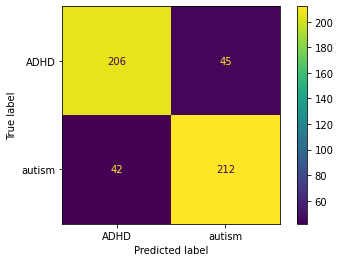

In [23]:
# plotting confusion matrix to visualize correct & incorrect predictions
preds1 = gs1.predict(X_test)

ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test);

The above test scores are promising. Our score is not so high that it may indicate overfitting, but it is also not so low that we might begin fearing for high bias. Overall, it looks like the model is predicting with roughly 83% accuracy on our test data. Let's try to improve the model using `TfidfVectorizer`.

#### 2b. Logistic Regression w/ TfidfVectorizer - Model 2

In [32]:
# pipe 2 = logistic reg w/ tfid
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()), # transformer
    ('logr', LogisticRegression()) # estimator
])


# parameters
pipe2_params = {
    'tvec__max_features': [500, 1000, 1500, 2000],
    'tvec__stop_words': ['english'],
    'tvec__min_df': [0.1, 0.2],
    'logr__penalty': ['l1', 'l2', 'none']
}

# 2nd grid search
gs2 = GridSearchCV(pipe2,
                  param_grid = pipe2_params,
                  n_jobs = -1)

In [33]:
# fitting on training data
gs2.fit(X_test, y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty,

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logr__penalty': ['l1', 'l2', 'none'],
                         'tvec__max_features': [500, 1000, 1500, 2000],
                         'tvec__min_df': [0.1, 0.2],
                         'tvec__stop_words': ['english']})

In [34]:
gs2.best_params_

{'logr__penalty': 'l2',
 'tvec__max_features': 500,
 'tvec__min_df': 0.1,
 'tvec__stop_words': 'english'}

In [35]:
print(f"Training Score: {gs2.score(X_train, y_train)}")
print(f"Testing Score:{gs2.score(X_test, y_test)}")

Training Score: 0.8228684732319894
Testing Score:0.8693069306930693


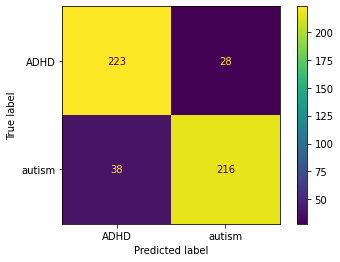

In [36]:
# plotting confusion matrix to visualize correct & incorrect predictions
preds2 = gs2.predict(X_test)

ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test);

This model performed much better on the test set with `TfidVectorizer` as the transformer. The testing score, however, was higher than the training. This might mean that the testing data could have had `post_title`'s that were slightly easier to predict. However, I think this still supports the earlier mention from the previous notebook that looking at frequency of certain words may help train the model better since some words will appear at greater frequency in r/ADHD vs. r/autism, and vice versa. <br>
I will build a few more models using different estimators now, but I will continue to use the `TfidVectorizer` as my transformer.

#### 2c. Multinomial Naive Bayes w/ TfidVectorizer - Model 3

For the 2nd set of models, I will use Multinomial Naive Bayes as the classifier. The model assumes independence across all features (in this case word frequency) and since we have ***several*** variables that are positive integers, this might be a strong performing model.

In [49]:
# pipe 3 = MB w/ tfid
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()), # transformer
    ('multi_nb', MultinomialNB()) # estimator
])


# parameters
pipe3_params = {
    'tvec__max_features': [500, 1000, 1500, 2000],
    'tvec__stop_words': ['english'],
    'tvec__min_df': [0.1, 0.2],
}

# 3rd grid search
gs3 = GridSearchCV(pipe3,
                  param_grid = pipe3_params,
                  n_jobs = -1)

In [50]:
# fitting data on train
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('multi_nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [500, 1000, 1500, 2000],
                         'tvec__min_df': [0.1, 0.2],
                         'tvec__stop_words': ['english']})

In [51]:
print(f"Training Score: {gs3.score(X_train, y_train)}")
print(f"Testing Score:{gs3.score(X_test, y_test)}")

Training Score: 0.8473231989424983
Testing Score:0.8297029702970297


This model's performance is roughly comparable to the first one. I will skip creating a confusion matrix visual for this. Instead, I will try one more model using the Random Forests estimator.

#### 2d. Random Forests w/ TfidVectorizer - Model 4

In [57]:
# pipe 3 = MB w/ tfid
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()), # transformer
    ('rf', RandomForestClassifier()) # estimator
])


# parameters
pipe4_params = {
    'tvec__max_features': [500, 1000, 1500, 2000, 3000, 4000, 5000],
    'tvec__stop_words': ['english'],
    'tvec__min_df': [0.1, 0.2],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3]
}

# 3rd grid search
gs4 = GridSearchCV(pipe4,
                  param_grid = pipe4_params,
                  n_jobs = -1)

In [58]:
# fit on training data
gs4.fit(X_train, y_train)

# this one took some time!

GridSearchCV(estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 1, 2, 3],
                         'rf__n_estimators': [50, 100, 150, 200],
                         'tvec__max_features': [500, 1000, 1500, 2000, 3000,
                                                4000, 5000],
                         'tvec__min_df': [0.1, 0.2],
                         'tvec__stop_words': ['english']})

In [62]:
gs4.best_params_

{'rf__max_depth': None,
 'rf__n_estimators': 200,
 'tvec__max_features': 2000,
 'tvec__min_df': 0.1,
 'tvec__stop_words': 'english'}

In [63]:
print(f"Training Score: {gs4.score(X_train, y_train)}")
print(f"Testing Score:{gs4.score(X_test, y_test)}")

Training Score: 0.9900859220092532
Testing Score:0.8534653465346534


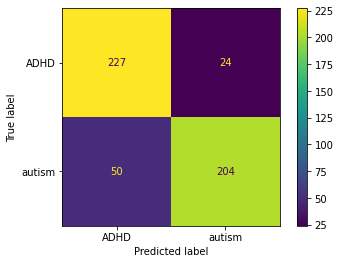

In [64]:
# plotting confusion matrix to visualize correct & incorrect predictions
preds4 = gs4.predict(X_test)

ConfusionMatrixDisplay.from_estimator(gs4, X_test, y_test);

This is a very interesting model. Its overall accuracy is comparable to Model 2, however, it doesn't do so well trying to predict for r/autism. Most of the misclassification is of the r/autism class. Unlike Model 4, Model 2 did a better job at overall accurately predicting classes in a balanced way. 

### 3. Final Evaluation & Conclusion

In [83]:
# displaying model scores as dataframe
scores_df = pd.DataFrame({"scores": [round(gs1.score(X_test, y_test),2),
                                    round(gs2.score(X_test, y_test), 2),
                                    round(gs3.score(X_test, y_test), 2),
                                    round(gs4.score(X_test, y_test), 2)]} , index = ['model 1', 'model 2', 'model 3', 'model 4'])

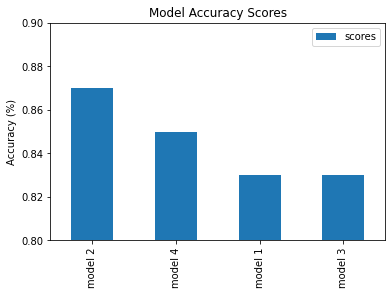

In [93]:
scores_df.sort_values(by = 'scores', ascending = False).plot(kind = 'bar')
plt.title("Model Accuracy Scores", size = 12)
plt.ylabel("Accuracy (%)", size = 10)
plt.ylim(0.8, 0.9)

plt.savefig('./graphs/model_scores.jpeg')

The clear winner, performance wise, is Model 2. It has a greater accuracy among the test data in predicting which subreddit a post (combined w/ its title) comes from. 

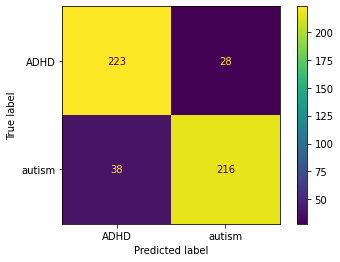

In [95]:
# save model 2 confusion matrix
ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test)
plt.savefig('./graphs/model2_confusion_matrix.jpeg');

To conclude, the best model (so far) to predict whether a post combined with its title comes from either r/ADHD or r/autism is the 2nd model which uses Logistic Regression as the classification estimator and term-frequency vectorization as the transformer. <br> 
Since we saw in the EDA that some words are definitely more apparent than others when splitting the two subreddits, using `TfidVectorizer` proved to be very useful and made a clearly stronger model. Looking at both the frequency and ***importance*** of the words is valuable especially because there are clear differences among the two subreddits. r/ADHD top unique words mostly included words that were names of medication and words synonymous with thinking, focus, and attention. Meanwhile, words in r/autism were instead focused on words synonymous with daily experiences and social situations.